<a href="https://colab.research.google.com/github/sadra-barikbin/latin-persian-to-farsi-alphabet/blob/main/seq2seq_fi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [88]:
!pip install tensorflow-text pytorch-ignite

     |████████████████████████████████| 251 kB 5.8 MB/s 


In [ ]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_text as text

<div style="direction:rtl">
    <h1>دادگان</h1>
</div>

In [ ]:
!wget 'https://raw.githubusercontent.com/language-ml/4-token-classification/main/Finglish2Persian/train.csv'
!wget 'https://raw.githubusercontent.com/language-ml/4-token-classification/main/Finglish2Persian/test.csv'

--2022-01-31 17:15:37--  https://raw.githubusercontent.com/language-ml/4-token-classification/main/Finglish2Persian/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223177 (218K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>] 217.95K  --.-KB/s    in 0.02s   

2022-01-31 17:15:37 (12.1 MB/s) - ‘train.csv’ saved [223177/223177]

--2022-01-31 17:15:37--  https://raw.githubusercontent.com/language-ml/4-token-classification/main/Finglish2Persian/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp latin-persian-to-farsi-alphabet-main.zip 'drive/My Drive'

In [ ]:
!unzip 'drive/My Drive/latin-persian-to-farsi-alphabet-main.zip'

Archive:  drive/My Drive/latin-persian-to-farsi-alphabet-main.zip
d5797b16b92d1e261543280aee69e46aa71eab8b
   creating: latin-persian-to-farsi-alphabet-main/
  inflating: latin-persian-to-farsi-alphabet-main/NLP-HW5.pdf  
  inflating: latin-persian-to-farsi-alphabet-main/README.md  
   creating: latin-persian-to-farsi-alphabet-main/checkpoints/
   creating: latin-persian-to-farsi-alphabet-main/checkpoints/train-pe/
  inflating: latin-persian-to-farsi-alphabet-main/checkpoints/train-pe/checkpoint  
  inflating: latin-persian-to-farsi-alphabet-main/checkpoints/train-pe/ckpt-1.data-00000-of-00001  
  inflating: latin-persian-to-farsi-alphabet-main/checkpoints/train-pe/ckpt-1.index  
   creating: latin-persian-to-farsi-alphabet-main/checkpoints/train/
  inflating: latin-persian-to-farsi-alphabet-main/checkpoints/train/checkpoint  
  inflating: latin-persian-to-farsi-alphabet-main/checkpoints/train/ckpt-1.data-00000-of-00001  
  inflating: latin-persian-to-farsi-alphabet-main/checkpoints/tr

In [ ]:
!mv latin-persian-to-farsi-alphabet-main/dataset .

In [ ]:
with open('dataset/fing.txt') as fp:
    fings = [l.strip() for l in fp.readlines()]

with open('dataset/pers.txt') as fp:
    pers = [l.strip() for l in fp.readlines()]
    

In [ ]:
train_df = pd.DataFrame({'Finglish': fings, 'Persian': pers})

In [ ]:
train_df = pd.read_csv('dataset/words.csv')

In [ ]:
train_df = train_df[train_df['Finglish'].str.find('object') == -1].copy()

In [ ]:
eval_df = pd.read_csv('train.csv').drop(['Unnamed: 0'], axis=1)

In [ ]:
eval_df

,Finglish,Persian
0,"az cheshmaaye pof kardat maloome, boro khodeto...",از چشمای پف کردت معلومه، برو خودتو فیلم کن بچه...
1,"haalaa, in mozoo be maa forsate ijaade chand s...",حالا، این موضوع به ما فرصت ایجاد چند سناریو را...
2,in tori ham digar raa sedaa bezanim,اینطوری همدیگه رو صدا بزنیم
3,revaayat haa shabih hamdigarand,روایتها شبیه همدیگرند
4,pesarak baa ta'ajob be medaad negaah kard va c...,پسرک با تعجب به مداد نگاه کرد و چیز خاصی در ان...
...,...,...
1686,dooste maadar shohar: to ke migofti yeki bemir...,دوست مادرشوهر:تو که میگفتی یکی بمیره من گریه ن...
1687,na man inaa ro azat shenidam.,نه من این رو ازت شنیدم
1688,zendeh tou atash besouzid.,زنده تو آتيش بسوزيد ؟
1689,azadeh aslan boro touyeh haman otagh behesh be...,ازاده اصلا برو توی همون اتاق بهش بده.


In [ ]:
train_data = zip(train_df['Finglish'], train_df['Persian'])
[(w, v) for v, w in train_data if v.find('object') == -1 and len(w) > 16]

[('تأثیرگذارخواهدبود', 'taayargzaarkhvaahdbood'),
 ('سیکلوتترادکاهپتان', 'seekloottraadkaahptaan')]

In [ ]:
START_TOKEN = '<'
END_TOKEN = '>'

In [ ]:
train_df['Persian'] = train_df['Persian'] + END_TOKEN

In [ ]:
eval_df['Persian'] = eval_df['Persian'] + END_TOKEN

In [ ]:
train_df.head()

,Unnamed: 0,Finglish,Persian
0,0,aaaaaataaaa,آآآتاآ>
1,1,aaaaaan,آآآن>
2,2,aaaakhreen,آآخرین>
3,3,aaaadoontaa,آآدونتا>
4,4,aaaar,آآر>
...,...,...,...
545084,545203,yayagrhaa,ییگرها>
545085,545204,yeegen,ییگن>
545086,545205,yayee,ییی>
545087,545206,yeeyaang,یییانگ>


In [ ]:
eval_df.head()

,Finglish,Persian
0,"az cheshmaaye pof kardat maloome, boro khodeto...",از چشمای پف کردت معلومه، برو خودتو فیلم کن بچه...
1,"haalaa, in mozoo be maa forsate ijaade chand s...",حالا، این موضوع به ما فرصت ایجاد چند سناریو را...
2,in tori ham digar raa sedaa bezanim,اینطوری همدیگه رو صدا بزنیم>
3,revaayat haa shabih hamdigarand,روایتها شبیه همدیگرند>
4,pesarak baa ta'ajob be medaad negaah kard va c...,پسرک با تعجب به مداد نگاه کرد و چیز خاصی در ان...


In [ ]:
train_df['Finglish'] = train_df['Finglish'].str.pad(width=25, side='right', fillchar='\0')
train_df['Persian'] = train_df['Persian'].str.pad(width=19, side='right', fillchar='\0')

In [ ]:
eval_df['Finglish'] = eval_df['Finglish'].str.pad(width=248, side='right', fillchar='\0')
eval_df['Persian'] = eval_df['Persian'].str.pad(width=180, side='right', fillchar='\0')

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df['Finglish'], train_df['Persian']))

In [ ]:
eval_ds = tf.data.Dataset.from_tensor_slices((eval_df['Finglish'], eval_df['Persian']))

In [ ]:
for fi_examples, pe_examples in train_ds.batch(3).take(1):
    for fi in fi_examples.numpy():
        print(fi.decode('utf-8'))
    
    print()
        
    for pe in pe_examples.numpy():
        print(pe.decode('utf-8'))

aaaaaataaaa              
aaaaaan                  
aaaakhreen               

آآآتاآ>            
آآآن>              
آآخرین>            


In [ ]:
for fi_examples, pe_examples in eval_ds.batch(3).take(1):
    for fi in fi_examples.numpy():
        print(fi.decode('utf-8'))
    
    print()
        
    for pe in pe_examples.numpy():
        print(pe.decode('utf-8'))

az cheshmaaye pof kardat maloome, boro khodeto film kon bache man khodam khatme harchi ghalamam.                                                                                                                                                        
haalaa, in mozoo be maa forsate ijaade chand senaariyo raa daad.                                                                                                                                                                                        
in tori ham digar raa sedaa bezanim                                                                                                                                                                                                                     

از چشمای پف کردت معلومه، برو خودتو فیلم کن بچه من خودم ختم هر چی قلمم.>                                                                                                             
حالا، این موضوع به ما فرصت ایجاد چند سناریو را داد،>                   

<div style="direction:rtl">
    <h1>تبدیل متن به دنباله‌ای از نویسه‌ها</h1>
</div>

In [ ]:
fi_chars = sorted(set(''.join(train_df['Finglish'])))[1:]
pe_chars = [START_TOKEN, END_TOKEN] + sorted(set(''.join(train_df['Persian'])))[2:]

In [ ]:
max([len(tr) for tr in train_df['Finglish']]), max([len(tr) for tr in train_df['Persian']])

(25, 19)

In [ ]:
max([len(ev) for ev in eval_df['Finglish']]), max([len(ev) for ev in eval_df['Persian']])

(248, 180)

<div style="direction:rtl">
    <h1>خط داده</h1>
</div>

In [ ]:
fi_string_lookup = tf.keras.layers.StringLookup(vocabulary=fi_chars)
pe_string_lookup = tf.keras.layers.StringLookup(vocabulary=pe_chars)


def tokenize_pairs(fi, pe):
    bsize = tf.shape(pe)[0]
    fi = tf.strings.unicode_split(fi, 'UTF-8')
    pe = tf.concat([tf.tile([[START_TOKEN]], [bsize, 1]), 
                    tf.strings.unicode_split(pe, 'UTF-8')], 1)
    return fi_string_lookup(fi).to_tensor(), pe_string_lookup(pe).to_tensor()

In [ ]:
tokenize_pairs(fi_examples, pe_examples)

Here's a simple input pipeline that processes, shuffles and batches the data:

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [ ]:
def make_batches(ds):
    return (
        ds
        .cache()
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
        .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_ds)
eval_batches = eval_ds.cache().batch(BATCH_SIZE)\
                              .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)\
                              .prefetch(tf.data.AUTOTUNE)

<div style="direction:rtl">
    <h1>کدگذاری مکانی</h1>
    با فرمول های زیر embedding مربوط به هر مکان را تولید می‌کنیم و اطلاعات آن را به مدل تزریق می‌کنیم.
</div>

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [ ]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

<div style="direction:rtl">
    <h1>مصور سازی</h1>
</div>

(1, 2048, 512)


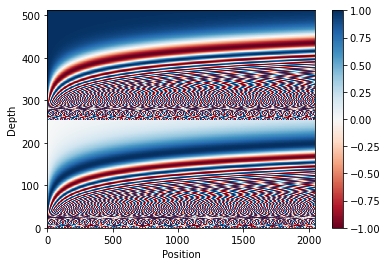

In [ ]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third token, only the first and second token will be used. Similarly to predict the fourth token, only the first, second and the third tokens will be used and so on.

In [ ]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [ ]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k\left(\frac{QK^T}{\sqrt{d_k}}\right) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `Q` and `K` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. So the *square root of `dk`* is used for scaling, so you get a consistent variance regardless of the value of `dk`. If the variance is too low the output may be too flat to optimize effectively. If the variance is too high the softmax may saturate at initialization making it difficult to learn.

The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the tokens you want to focus on are kept as-is and the irrelevant tokens are flushed out.

In [ ]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print('Attention weights are:')
    print(temp_attn)
    print('Output is:')
    print(temp_out)

In [ ]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [ ]:
# This query aligns with a repeated key (third and fourth),
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [ ]:
# This query aligns equally with the first and second key,
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Pass all the queries together.

In [ ]:
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers.
*    Scaled dot-product attention.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers before the multi-head attention function.

In the diagram above `(K,Q,V)` are passed through sepearte linear (`Dense`) layers for each attention head. For simplicity/efficiency the code below implements this using a single dense layer with `num_heads` times as many outputs. The output is rearranged to a shape of `(batch, num_heads, ...)` before applying the attention function.

The `scaled_dot_product_attention` function defined above is applied in a single call, broadcasted for efficiency. An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information from different representation subspaces at different positions. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [ ]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [ ]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](https://www.tensorflow.org/text/tutorials/nmt_with_attention.ipynb). 

* The input sentence is passed through `N` encoder layers that generates an output for each token in the sequence.
* The decoder attends to the encoder's output and its own input (self-attention) to predict the next word. 

### Encoder layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [ ]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next token by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [ ]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [ ]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [ ]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                                 input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs, training):
        # Keras models prefer if you pass all your inputs in the first argument
        inp, tar = inputs

        enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, 
                                                     look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

    def create_masks(self, inp, tar):
        # Encoder padding mask
        enc_padding_mask = create_padding_mask(inp)

        # Used in the 2nd attention block in the decoder.
        # This padding mask is used to mask the encoder outputs.
        dec_padding_mask = create_padding_mask(inp)

        # Used in the 1st attention block in the decoder.
        # It is used to pad and mask future tokens in the input received by
        # the decoder.
        look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
        dec_target_padding_mask = create_padding_mask(tar)
        look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

        return enc_padding_mask, look_ahead_mask, dec_padding_mask

In [ ]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([temp_input, temp_target], training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Set hyperparameters

To keep this example small and relatively fast, the values for `num_layers, d_model, dff` have been reduced. 

The base model described in the [paper](https://arxiv.org/abs/1706.03762) used: `num_layers=6, d_model=512, dff=2048`.

In [ ]:
num_layers = 2
d_model = 32
dff = 64
num_heads = 8
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$


In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

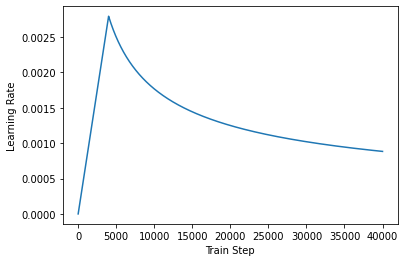

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [90]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred): # Measures character by character equality separately.
                                   # That is as if each character in a sentence is measured.
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

from ignite.metrics.nlp import Bleu
def bleu_function(real, pred):
  indices = tf.argmax(pred, axis=2)
  hypotheses = [list(indices[i][real[i]!=0].numpy()) for i in range(len(real))]
  references = [[list(real[i][real[i]!=0].numpy())] for i in range(len(real))]
  m = Bleu(ngram=4, smooth="smooth1")
  m.update((hypotheses, references))
  return m.compute()

In [91]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
eval_accuracy = tf.keras.metrics.Mean(name='eval_accuracy')
eval_bleu = tf.keras.metrics.Mean(name='eval_bleu')

## Training and checkpointing

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=len(fi_chars) + 1,
    target_vocab_size=len(pe_chars) + 1,
    pe_input=300,
    pe_target=300,
    rate=dropout_rate)

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [ ]:
!mv latin-persian-to-farsi-alphabet-main/checkpoints .

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

Latest checkpoint restored!!


The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

During training this example uses teacher-forcing (like in the [text generation tutorial](https://www.tensorflow.org/text/tutorials/text_generation)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each token, *self-attention* allows it to look at the previous tokens in the input sequence to better predict the next token.

To prevent the model from peeking at the expected output the model uses a look-ahead mask.

In [ ]:
EPOCHS = 3

In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    with tf.GradientTape() as tape:
        predictions, _ = transformer([inp, tar_inp],
                                     training = True)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [100]:
eval_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


# @tf.function(input_signature=eval_step_signature)
def eval_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    predictions, _ = transformer([inp, tar_inp],
                                  training = False)

    eval_accuracy(accuracy_function(tar_real, predictions))
    eval_bleu(bleu_function(tar_real, predictions))

In [101]:
eval_accuracy.reset_states()
eval_bleu.reset_states()
for (batch, (inp, tar)) in enumerate(eval_batches):
  eval_step(inp, tar)
print(f'Validation Accuracy {eval_accuracy.result():.4f}')
print(f'Validation BLEU {eval_bleu.result():.4f}')

Validation Accuracy 0.2210
Validation BLEU 0.1177


In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 3 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 4.1216 Accuracy 0.0319
Epoch 1 Batch 50 Loss 4.0396 Accuracy 0.0390
Epoch 1 Batch 100 Loss 3.8542 Accuracy 0.0559
Epoch 1 Batch 150 Loss 3.6782 Accuracy 0.0734
Epoch 1 Batch 200 Loss 3.5547 Accuracy 0.0947
Epoch 1 Batch 250 Loss 3.4508 Accuracy 0.1160
Epoch 1 Batch 300 Loss 3.3553 Accuracy 0.1364
Epoch 1 Batch 350 Loss 3.2609 Accuracy 0.1552
Epoch 1 Batch 400 Loss 3.1679 Accuracy 0.1741
Epoch 1 Batch 450 Loss 3.0793 Accuracy 0.1940
Epoch 1 Batch 500 Loss 3.0004 Accuracy 0.2116
Epoch 1 Batch 550 Loss 2.9259 Accuracy 0.2286
Epoch 1 Batch 600 Loss 2.8566 Accuracy 0.2450
Epoch 1 Batch 650 Loss 2.7895 Accuracy 0.2612
Epoch 1 Batch 700 Loss 2.7246 Accuracy 0.2771
Epoch 1 Batch 750 Loss 2.6601 Accuracy 0.2931
Epoch 1 Batch 800 Loss 2.5973 Accuracy 0.3086
Epoch 1 Batch 850 Loss 2.5328 Accuracy 0.3245
Epoch 1 Batch 900 Loss 2.4684 Accuracy 0.3407
Epoch 1 Batch 950 Loss 2.4030 Accuracy 0.3572
Epoch 1 Batch 1000 Loss 2.3379 Accuracy 0.3739
Epoch 1 Batch 1050 Loss 2.2732 Accur

### Run inference

The following steps are used for inference:

* Encode the input sentence using the Portuguese tokenizer (`tokenizers.pt`). This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next token based on the previous tokens it predicted.

Note: The model is optimized for _efficient training_ and makes a next-token prediction for each token in the output simultaneously. This is redundant during inference, and only the last prediction is used.  This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (`training=False`).

In [ ]:
class Translator(tf.Module):
    def __init__(self, src_vocab, dest_vocab, transformer):
        self.src_lookup = tf.keras.layers.StringLookup(vocabulary=src_vocab)
        self.dest_lookup = tf.keras.layers.StringLookup(vocabulary=dest_vocab, invert=True)
        self.transformer = transformer

    def __call__(self, word, max_length=20):
        # input sentence is portuguese, hence adding the start and end token
        assert isinstance(word, tf.Tensor)
        if len(word.shape) == 0:
            word = word[tf.newaxis]
        
        word_bytes = tf.strings.unicode_split(word, 'UTF-8')
        
        encoder_input = self.src_lookup(word_bytes).to_tensor()
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output_array = output_array.write(0, [1])

        for i in tf.range(max_length):
            output = tf.transpose(output_array.stack())
            predictions, _ = self.transformer([encoder_input, output], training=False)

            # select the last token from the seq_len dimension
            predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

            predicted_id = tf.argmax(predictions, axis=-1)

            # concatentate the predicted_id to the output which is given to the decoder
            # as its input.
            output_array = output_array.write(i+1, predicted_id[0])

            if predicted_id == 2:
                break

        output = tf.transpose(output_array.stack())
        # output.shape (1, tokens)
        text = tf.strings.join(self.dest_lookup(output)[0])  # shape: ()

        return text

Create an instance of this `Translator` class, and try it out a few times:

In [ ]:
translator = Translator(fi_chars, pe_chars, transformer)

In [ ]:
def print_translation(sentence, tokens, ground_truth):
    print(f'{"Input:":15s}: {sentence}')
    print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
    print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
sentence = "man"
ground_truth = "بیا"

translated_text = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : man
Prediction     : <من>
Ground truth   : بیا


In [ ]:
def translate_sentence(sentence):
    target_seq = []
    for word in sentence.split():
        translated_word = translator(tf.constant(word)).numpy().decode("utf-8")[1:-1]
        target_seq.append(translated_word)
    return ' '.join(target_seq)

In [ ]:
test_df = pd.read_csv('dataset/test.csv')

In [ ]:
test_fi_df = test_df[test_df['Persian'].isnull()]
test_pe_df = test_df[test_df['Finglish'].isnull()]

In [ ]:
test_fi_df['Persian'] = [translate_sentence(s) for s in test_fi_df['Finglish']]

<ipython-input-124-949c069a1af5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_fi_df['Persian'] = [translate_sentence(s) for s in test_fi_df['Finglish']]


In [ ]:
test_fi_df = test_fi_df.reset_index(drop=True)

In [ ]:
test_fi_df.to_csv()

,Unnamed: 0,Finglish,Persian
0,0,man faghat mikhastam begouyam man.,من فگهت مخستم بگویم من
1,1,edi joei aan raa dide?,ید جوئه آن را ددی
2,2,va maa do emtiyaaz aghabim.,ووا ما دو ممتیاز گهبمم
3,3,tavousi dar daasht par ha ye khod ra mikand va...,تووس در داشت پر ها ییه کود را مکند ووا دور مرختت
4,4,man yek daanesh pazhoohe haafeze hastam.,من یک دانش پژوهه هافزه هستم
...,...,...,...
111,111,parkhaashgari nemikonan!,پرخاشگر نمککونن
112,112,"shohar jan, nailon e meshki e koochak darim?",شوهر جن نللن یی مشک یی کوچک درم
113,113,ye khorde azash khosham oomad.,ییه خرده زاش خوشم وومد
114,114,"va badtar az aan, hengaami ke maa zavaabet va ...",ووا بدتر آن هنگام کیثه ما زوابت ووا شرایت را ...


## Export

That inference model is working, so next you'll export it as a `tf.saved_model`.

To do that, wrap it in yet another `tf.Module` sub-class, this time with a `tf.function` on the `__call__` method:

In [ ]:
class ExportTranslator(tf.Module):
    def __init__(self, translator):
        self.translator = translator

    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def __call__(self, sentence):
        (result, 
         tokens,
         attention_weights) = self.translator(sentence, max_length=100)

    return result

In the above `tf.function` only the output sentence is returned. Thanks to the [non-strict execution](https://tensorflow.org/guide/intro_to_graphs) in `tf.function` any unnecessary values are never computed.

In [ ]:
translator = ExportTranslator(translator)

Since the model is decoding the predictions using `tf.argmax` the predictions are deterministic. The original model and one reloaded from its `SavedModel` should give identical predictions:

In [ ]:
translator("este é o primeiro livro que eu fiz.").numpy()

b'this is the first book i did .'

In [ ]:
tf.saved_model.save(translator, export_dir='translator')

2021-11-02 15:48:30.232789: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [ ]:
reloaded = tf.saved_model.load('translator')

In [ ]:
reloaded("este é o primeiro livro que eu fiz.").numpy()

b'this is the first book i did .'